In [1]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, Activation, Bidirectional, LSTM,Conv1D,MaxPooling1D
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
import pandas as pd
import os,random,math

TRAINING_DIR="propaganda_dataset_v2"
files=os.listdir(TRAINING_DIR)
#since we have just two files we dont need loops
traindf= pd.read_csv(os.path.join(TRAINING_DIR,files[0]),sep = '\t')
testdf= pd.read_csv(os.path.join(TRAINING_DIR,files[1]),sep = '\t')


def convert_text(sentences):
    start_sent=sentences.split("<BOS>")
    end_sent=start_sent[1].split("<EOS>")
    return end_sent[0]

testdf["tagged_in_context"]=testdf["tagged_in_context"].map(convert_text)
traindf["tagged_in_context"]=traindf["tagged_in_context"].map(convert_text)

testdf.head(10)

,label,tagged_in_context
0,not_propaganda,according to a UN estimate.
1,causal_oversimplification,the country would not last long without an ou...
2,appeal_to_fear_prejudice,gets Earl Warren and Sen. Richard Russel to j...
3,not_propaganda,You
4,repetition,infidels
5,"name_calling,labeling","the ""gay lifestyle"
6,loaded_language,devastating communities
7,not_propaganda,Jacob
8,flag_waving,Iran’s long rap sheet of aggression against A...
9,doubt,"Now, the pope’s reply to my testimony was: “I..."


In [3]:
def convert_labels_multiclass(label):
    if label=="flag_waving":
        return 0
    elif label=="appeal_to_fear_prejudice":
        return 1
    elif label=="causal_oversimplification":
        return 2
    elif label =="doubt":
        return 3
    elif label == "exaggeration,minimisation":
        return 4
    elif label == "loaded_language":
        return 5
    elif label == "name_calling,labeling":
        return 6
    elif label == "repetition":
        return 7
     
#drop rows with no propanganda

testdf=testdf[testdf.label != "not_propaganda"]
traindf = traindf[traindf.label != "not_propaganda"]

traindf["label"] = traindf["label"].map(convert_labels_multiclass)
testdf["label"] = testdf["label"].map(convert_labels_multiclass)

traindf.reset_index(inplace=True)
testdf.reset_index(inplace = True)

In [4]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stops = stopwords.words('english')
    #print(stops)
    
    return sentence.lower()

In [5]:
testdf["tagged_in_context"]=testdf["tagged_in_context"].map(preprocess_text)
traindf["tagged_in_context"]=traindf["tagged_in_context"].map(preprocess_text)

In [6]:
from keras.utils import to_categorical
y_train = to_categorical(traindf["label"])
y_test = to_categorical(testdf["label"])

In [7]:
from keras.preprocessing.text import Tokenizer
no_words=10000
tokenizer=Tokenizer(num_words=no_words,lower=True)

In [9]:
mes = []
for i in testdf['tagged_in_context']:
    mes.append(i.split())
for i in traindf['tagged_in_context']:
    mes.append(i.split())

In [10]:
tokenizer.fit_on_texts(mes)

In [11]:
X_train=tokenizer.texts_to_sequences(traindf["tagged_in_context"]) # this converts texts into some numeric sequences 
X_train_pad=pad_sequences(X_train,maxlen=140,padding='post') # this makes the length of all numeric sequences equal 
X_test = tokenizer.texts_to_sequences(testdf["tagged_in_context"])
X_test_pad = pad_sequences(X_test, maxlen = 140, padding = 'post')

In [12]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100')

In [14]:
vector_size = 100
gensim_weight_matrix = np.zeros((no_words ,vector_size))
gensim_weight_matrix.shape
words = list(glove_gensim.key_to_index.keys())
for word, index in tokenizer.word_index.items():
    if index < no_words: # since index starts with zero 
        if word in  words:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [15]:
EMBEDDING_DIM = 100
class_num = 2
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(input_dim = no_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 140, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
Total params: 1,063,640
Trainable params: 63,640
Non-trainable params: 1,000,000
_______________________________________

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./CNNLASTMmodel.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [17]:
history_embedding = model.fit(X_train_pad, y_train, 
                                epochs = 25, batch_size = 120, 
                                validation_data=(X_test_pad, y_test),
                                verbose = 1, callbacks= [es, mc]  )

Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 2.0800 - accuracy: 0.1137
Epoch 1: val_accuracy improved from -inf to 0.10036, saving model to .\CNNLASTMmodel.h5
11/11 [==============================] - 14s 106ms/step - loss: 2.0800 - accuracy: 0.1137 - val_loss: 2.0804 - val_accuracy: 0.1004
Epoch 2/25
10/11 [==========================>...] - ETA: 0s - loss: 2.0775 - accuracy: 0.1400
Epoch 2: val_accuracy improved from 0.10036 to 0.13620, saving model to .\CNNLASTMmodel.h5
11/11 [==============================] - 0s 40ms/step - loss: 2.0774 - accuracy: 0.1406 - val_loss: 2.0428 - val_accuracy: 0.1362
Epoch 3/25
 9/11 [=======================>......] - ETA: 0s - loss: 1.9747 - accuracy: 0.1880
Epoch 3: val_accuracy improved from 0.13620 to 0.18996, saving model to .\CNNLASTMmodel.h5
11/11 [==============================] - 0s 37ms/step - loss: 1.9709 - accuracy: 0.1897 - val_loss: 1.9506 - val_accuracy: 0.1900
Epoch 4/25
 9/11 [=======================>......] - ETA:

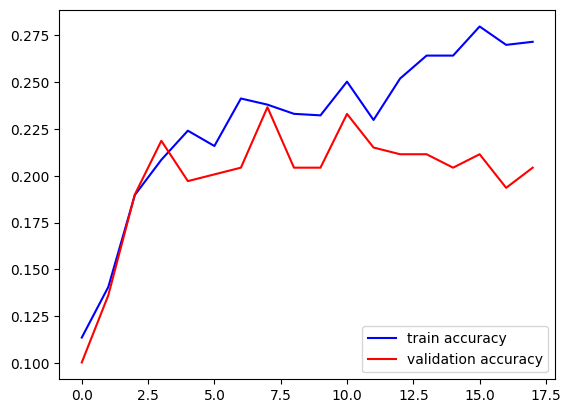

In [18]:
import matplotlib.pyplot as plt
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [19]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

9/9 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.21      0.35       147
           3       0.00      0.00      0.00         0
           4       0.25      0.21      0.23        34
           5       0.08      0.12      0.10        24
           6       0.52      0.22      0.30        74
           7       0.00      0.00      0.00         0

    accuracy                           0.20       279
   macro avg       0.23      0.09      0.12       279
weighted avg       0.70      0.20      0.30       279



c:\Users\loges\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\loges\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\loges\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
